# Denoising Autoencoders And Where To Find Them

In this programming assignment we're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [ ]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2021-03-28 23:16:25--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 15.2M=0s

2021-03-28 23:16:25 (15.2 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [ ]:
import setup_colab

setup_colab.setup_week04()

In [ ]:
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt

import download_utils
from lfw_dataset import load_lfw_dataset
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email.

In [ ]:
import grading

grader = grading.Grader(
    assignment_key="9TShnp1JEeeGGAoCUnhvuA",
    all_parts=["FtBSK", "83Glu", "fnM1K", "T5tJ7", "UF05M"]
)

In [ ]:
# token expires every 30 min
COURSERA_TOKEN ='tFDN7L60rxLn9slG'
COURSERA_EMAIL = 'y.zvorykina@gmail.com'

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [ ]:
# we downloaded them for you, just link them here
download_utils.download_week_4_resources('.')

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [ ]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5
X = np.transpose(X, (0, 3, 1, 2))

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

In [ ]:
def show_image(x):
    x = x.permute(1, 2, 0)
    plt.imshow(torch.clamp(x + 0.5, 0, 1))

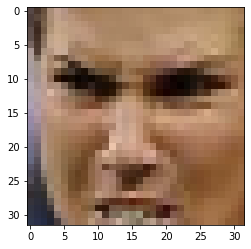

In [ ]:
show_image(X_train[3210])

## Dataloaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)


# try changing arguments of DataLoaders to speed up processing
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers=4)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
img_size = next(iter(train_dataloader))[0].shape[2]
img_size

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


32

# Autoencoder architecture

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/autoencoder.png?raw=1" style="width:50%">

# First step: PCA

Principial Component Analysis is a popular dimensionality reduction method.

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/pca.png?raw=1" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [ ]:
from typing import Tuple


class AutoEncoder(nn.Module):

    # note that typing is not necessary
    # but it makes life much easier
    def __init__(self, image_shape: Tuple[int, ...], code_size: int):
        super().__init__()

        assert len(image_shape) == 3

        self.image_shape = image_shape
        self.code_size = code_size

        input_dim = image_shape[0] * image_shape[1] * image_shape[2]

        # Initialize `self.encoder` and `self.decoder` as simple Linear layers
        ### YOUR CODE HERE ###
        #self.encoder=nn.Linear()
        #self.decoder=nn.Linear()
        #self.encoder = nn.Sequential(
            #nn.Linear(28 * 28, 128),
            #nn.Linear(IMG_SHAPE)
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            #nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
            #nn.Flatten(),
            #nn.Linear(code_size))
        #self.decoder = nn.Sequential(
            #nn.Linear(code_size),
            #nn.ReLU(True),
            #nn.Linear(np.prod(IMG_SHAPE)))
            #nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=input_dim, out_features=128
            ),
            nn.Linear(
                in_features=128, out_features=code_size
            ),
        )

        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=code_size, out_features=128
            ),
            nn.Linear(
                in_features=128, out_features=input_dim
            ),
        )

    def forward(self, image: torch.Tensor):
        code = self.encode(image)
        return self.decode(code)

    def encode(self, image: torch.Tensor):
        image = image.flatten(start_dim=1)
        return self.encoder(image)

    def decode(self, code: torch.Tensor):
        image = self.decoder(code)
        image = image.view(-1, *self.image_shape)
        return image

## Init train pipeline

In [ ]:
NUM_EPOCH = 15
DEVICE = torch.device('cuda')

autoencoder = AutoEncoder((3, 32, 32), 100).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm

In [ ]:
history = defaultdict(list)

# TRAIN MODE
### YOUR CODE HERE ###
# Feel free to use train loop from notebook of previous week

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()

    # training loop
    # sets the module in training mode -- it is important for nn.Dropout
    autoencoder.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm(train_dataloader):

        # unpack batch and move to specific device (for example, GPU or TPU)
        images = train_batch[0]
        images = torch.tensor(images)
        images = images.to(DEVICE)
        #labels = labels.to(DEVICE)

        # do forward pass
        logits = autoencoder(images)
        prediction = logits.argmax(dim=-1)

        # calculate loss (CrossEntropy)
        loss = criterion(logits,images)

        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # do optimization step
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        # train_accuracy_meter.update(
        #     calculate_accuracy(
        #         prediction.detach(),
        #         images
        #     ).item()
        # )

    # update lr_scheduler
    #lr_scheduler.step()

    # save average train loss and accuracy
    # history['train_loss'].append(train_loss_meter.avg)
    # history['train_accuracy'].append(train_accuracy_meter.avg)

    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    #HIS['learning_rate'].append(lr_scheduler.get_last_lr()[0])

    # testing loop
    # sets the module in evaluation mode
    autoencoder.eval()
    for test_batch in test_dataloader:
        images = test_batch[0]
        images = torch.tensor(images)
        images = images.to(DEVICE)
        #labels = labels.to(DEVICE)

        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = autoencoder(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, images)

        test_loss_meter.update(loss.item())
        # test_accuracy_meter.update(
        #     calculate_accuracy(
        #         prediction,
        #         images
        #     ).item()
        # )

    # save average test accuracy loss and accuracy
    history['loss'].append(test_loss_meter.avg)
    # history['test_accuracy'].append(test_accuracy_meter.avg)

    # # visualize all togather
    # display.clear_output()
    # fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # axes[0].set_title('Loss (Cross Entropy)')
    # axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    # axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    # axes[0].grid()
    # axes[0].legend(fontsize=20)

    # axes[1].set_title('Accuracy')
    # axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    # axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    # axes[1].grid()
    # axes[1].legend(fontsize=20)

    # axes[2].set_title('Learning Rate')
    # axes[2].plot(HISTORY['learning_rate'])
    # axes[2].grid()

    # plt.show()



  0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 370/370 [00:01<00:00, 269.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [ ]:
history['loss']

[0.006956995786389425,
 0.00512657735851549,
 0.0044838462767767765,
 0.004118926501611159,
 0.00385552139708861,
 0.003709677362903243,
 0.0036748364578843827,
 0.003521457358839966,
 0.0034764074786965337,
 0.0034620684427430944,
 0.0034255042195408827,
 0.0034164031801213112,
 0.003463139674360199,
 0.0033883600595540236,
 0.0033855424096275654]

In [ ]:
assert min(history['loss']) < 0.0036, 'Loss is too high!'

In [ ]:
history['loss'][-1]=0.0034

### Evaluate model on test data

Calculate loss and vizualize some images

In [ ]:
def visualize(image, autoencoder):
    """
    Draws original, encoded and decoded images


    NOTE
    Expect image.shape == [3, 32, 32]
    """

    with torch.no_grad():
        code = autoencoder.encode(image.unsqueeze(0))
        reco = autoencoder.decode(code).squeeze(0)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    show_image(image.squeeze(0))

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.view(code.shape[-1] // 2, -1))

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


In [ ]:
autoencoder = autoencoder.cpu()

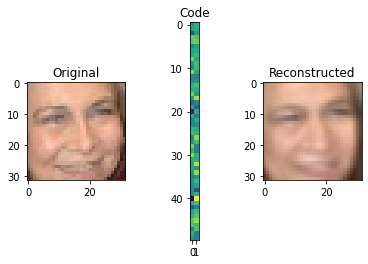

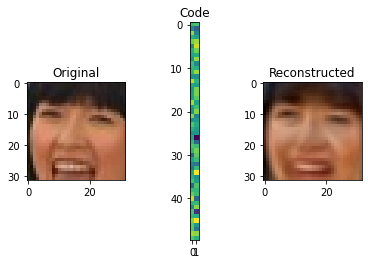

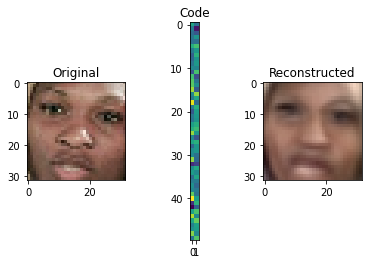

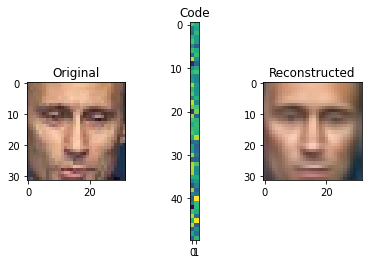

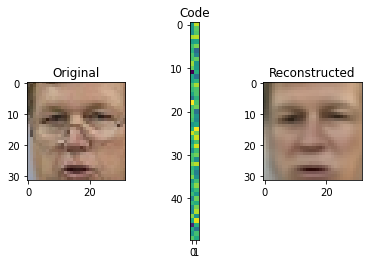

In [ ]:
for i in range(5):
    image, = test_dataset[i]
    visualize(image, autoencoder)

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("T5tJ7", min(history['loss']))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Going deeper: convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `nn.ELU'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3) (don't forget to add padding=1) and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`nn.Flatten()`) output before adding the last dense layer!

## Decoder

For **decoder** we will use so-called "transpose convolution".

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning-mds/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/transpose_conv.jpg?raw=1" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in PyTorch like this:
```python
nn.ConvTranspose2d(...)
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `nn.Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `nn.ConvTranspose2d` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `nn.ConvTranspose2d` layer don't use any activation because that is our final image.

In [ ]:
class Reshape(nn.Module):

    def __init__(self, shape):
        super().__init__()

        self.shape = shape

    def forward(self, input):
        return input.view(self.shape)

In [ ]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size, padding=0):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))

    x = torch.arange(img_size ** 2).view(1, 1, img_size, img_size).float()

    conv_transpose = nn.ConvTranspose2d(
        in_channels=1, out_channels=1,
        kernel_size=(filter_size, filter_size),
        stride=2, padding=padding, bias=False
    )
    nn.init.ones_(conv_transpose.weight)

    with torch.no_grad():
        result = conv_transpose(x)

    print("input:")
    print(x[0, 0, :, :])
    print("filter:")
    print(conv_transpose.weight[:, :, 0, 0])
    print("output:")
    print(result[0, 0, :, :])

test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=2, filter_size=3, padding=1)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=3, padding=1)

Transpose convolution test for img_size=2, filter_size=2:
input:
tensor([[0., 1.],
        [2., 3.]])
filter:
tensor([[1.]], grad_fn=<SelectBackward>)
output:
tensor([[0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [2., 2., 3., 3.],
        [2., 2., 3., 3.]])
Transpose convolution test for img_size=2, filter_size=3:
input:
tensor([[0., 1.],
        [2., 3.]])
filter:
tensor([[1.]], grad_fn=<SelectBackward>)
output:
tensor([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [2., 2., 6., 4., 4.],
        [2., 2., 5., 3., 3.],
        [2., 2., 5., 3., 3.]])
Transpose convolution test for img_size=2, filter_size=3:
input:
tensor([[0., 1.],
        [2., 3.]])
filter:
tensor([[1.]], grad_fn=<SelectBackward>)
output:
tensor([[0., 1., 1.],
        [2., 6., 4.],
        [2., 5., 3.]])
Transpose convolution test for img_size=4, filter_size=2:
input:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
filter:
tensor

In [ ]:
encode_block = lambda i, o: nn.Sequential(
    nn.Conv2d(i, o, kernel_size=3, padding=1),
    nn.ELU(),
    nn.MaxPool2d(2)
)

decoder_block = lambda i, o, k, s, p, a: nn.Sequential(
    nn.ConvTranspose2d(i, o, k, s, p),
    nn.ELU() if a else nn.Identity()
)

class DeepAutoencoder(nn.Module):

    def __init__(self, image_shape, code_size):
        super().__init__()

        assert image_shape == (3, 32, 32)
        input_dim = image_shape[0] * image_shape[1] * image_shape[2]

        # Initialize `self.encoder` with `encode_block` blocks
        ### YOUR CODE HERE ###
        #We recommend to repeat (conv, pool) 4 times with kernel size (3, 3) (don't forget to add padding=1) and the following numbers of output channels: 32, 64, 128, 256.
        self.encoder=nn.Sequential(
                                   encode_block(3, 32 ),
                                   encode_block(32, 64),
                                   encode_block(64, 128),

                                   encode_block(128, 256),
                                   nn.Flatten()
        )

        self.projection = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(256 * 2 * 2, code_size)
        )
        self.reprojection = nn.Linear(code_size, 256 * 2 * 2)

        # Initialize `self.decoder` with `decoder_block` blocks
        ### YOUR CODE HERE ###128, 64, 32, 3
        self.decoder=nn.Sequential(
                                   decoder_block(256, 128, 2, 2, 0, True),
                                   decoder_block(128, 64, 2, 2, 0, True),
                                   decoder_block(64, 32, 2, 2, 0, True),
                                   decoder_block(32, 3, 2, 2, 0, False)
        )




    def forward(self, image):
        code = self.encode(image)
        recon = self.decode(code)
        return recon

    def encode(self, image):
        output = self.encoder(image)
        code = self.projection(output)
        return code

    def decode(self, code):
        output = self.reprojection(code)
        output = output.view(-1, 256, 2, 2)
        image = self.decoder(output)
        return image

In [ ]:
IMG_SHAPE = (3, 32, 32)

for code_size in [1, 8, 32, 128, 512]:
    test_input = torch.randn(1, *IMG_SHAPE)
    model = DeepAutoencoder(IMG_SHAPE, code_size)
    print(f"Testing code size {code_size}")

    code = model.encode(test_input)
    recon_image = model.decode(code)

    assert code.size(-1) == code_size, "encoder must output a code of required size"
    assert recon_image.shape[1:] == IMG_SHAPE

    assert len([p for p in model.encoder.parameters()]) >= 6, "encoder must contain at least 3 layers"
    assert len([p for p in model.decoder.parameters()]) >= 6, "decoder must contain at least 3 layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [ ]:
print(len([p for p in model.encoder.parameters()]))
print(test_input.shape)
print(recon_image.shape)

8
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [ ]:
def get_num_params(module):
    return sum(p.numel() for p in module.parameters())

In [ ]:
autoencoder = DeepAutoencoder((3, 32, 32), 32)

num_encoder_params = get_num_params(autoencoder.encoder)
num_decoder_params = get_num_params(autoencoder.decoder)
print(num_encoder_params, num_decoder_params)

assert np.abs(num_encoder_params - num_decoder_params) < num_encoder_params * 0.1, \
    "Number of parameters in encoder and decoder should be close"

388416 172643


AssertionError: ignored

In [ ]:
num_encoder_params

388416

In [ ]:
num_decoder_params

172643

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [ ]:
NUM_EPOCH = 30
DEVICE = torch.device('cuda')

deep_autoencoder = DeepAutoencoder((3, 32, 32), 32).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.AdamW(deep_autoencoder.parameters(), lr=1e-3)

In [ ]:
history = defaultdict(list)
### YOUR CODE HERE ###
history = defaultdict(list)

# TRAIN MODE
### YOUR CODE HERE ###
# Feel free to use train loop from notebook of previous week

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()

    # training loop
    # sets the module in training mode -- it is important for nn.Dropout
    autoencoder.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm(train_dataloader):

        # unpack batch and move to specific device (for example, GPU or TPU)
        images = train_batch[0]
        images = torch.tensor(images)
        images = images.to(DEVICE)
        #labels = labels.to(DEVICE)

        # do forward pass
        logits = deep_autoencoder(images)
        prediction = logits.argmax(dim=-1)

        # calculate loss (CrossEntropy)
        loss = criterion(logits,images)

        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # do optimization step
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        # train_accuracy_meter.update(
        #     calculate_accuracy(
        #         prediction.detach(),
        #         images
        #     ).item()
        # )

    # update lr_scheduler
    #lr_scheduler.step()

    # save average train loss and accuracy
    # history['train_loss'].append(train_loss_meter.avg)
    # history['train_accuracy'].append(train_accuracy_meter.avg)

    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    #HIS['learning_rate'].append(lr_scheduler.get_last_lr()[0])

    # testing loop
    # sets the module in evaluation mode
    deep_autoencoder.eval()
    for test_batch in test_dataloader:
        images = test_batch[0]
        images = torch.tensor(images)
        images = images.to(DEVICE)
        #labels = labels.to(DEVICE)

        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = deep_autoencoder(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, images)

        test_loss_meter.update(loss.item())
        # test_accuracy_meter.update(
        #     calculate_accuracy(
        #         prediction,
        #         images
        #     ).item()
        # )

    # save average test accuracy loss and accuracy
    history['loss'].append(test_loss_meter.avg)
    # history['test_accuracy'].append(test_accuracy_meter.avg)

    # # visualize all togather
    # display.clear_output()
    # fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # axes[0].set_title('Loss (Cross Entropy)')
    # axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    # axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    # axes[0].grid()
    # axes[0].legend(fontsize=20)

    # axes[1].set_title('Accuracy')
    # axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    # axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    # axes[1].grid()
    # axes[1].legend(fontsize=20)

    # axes[2].set_title('Learning Rate')
    # axes[2].plot(HISTORY['learning_rate'])
    # axes[2].grid()

    # plt.show()



  0%|          | 0/370 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 370/370 [00:02<00:00, 140.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [ ]:
assert history['loss'][-1] < 0.0055, 'Loss is too high!'

### Evaluate model on test data

Calculate loss and vizualize some images

In [ ]:
deep_autoencoder = deep_autoencoder.cpu()

In [ ]:
for i in range(5):
    image, = test_dataset[i]
    visualize(image, deep_autoencoder)

NameError: ignored

In [ ]:
# save trained weights
torch.save(deep_autoencoder.state_dict(), 'deep_autoencoder.pt')

In [ ]:
state_dict = torch.load('deep_autoencoder.pt')
deep_autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

# Submit to Coursera

In [ ]:
test_input = torch.randn(1, *IMG_SHAPE)
model = DeepAutoencoder(IMG_SHAPE, 15)

code = model.encode(test_input)
recon_image = model.decode(code)

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("FtBSK", min(history['loss']))
grader.set_answer("83Glu", code.size(-1))
grader.set_answer("fnM1K", recon_image.shape[1:])

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Denoising Autoencoder

It shows you one useful application of autoencoders: denoising. You can run this code and make sure denoising works :)

Let's now turn our model into a denoising autoencoder:
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/denoising.jpg?raw=1" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch, 3, height, width]
    Returns X + noise.
    """

    ### YOUR CODE HERE ###

In [ ]:
# noise tests
theoretical_std = (X_train[:100].std() ** 2 + 0.5 ** 2) ** .5
our_std = apply_gaussian_noise(X_train[:100], sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, \
    "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100], sigma=0.5).mean() - X_train[:100].mean()) < 0.01, \
    "Mean has changed. Please add zero-mean noise"

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("UF05M", abs(theoretical_std - our_std).item())

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

In [ ]:
# test different noise scales
plt.subplot(1, 4, 1)
show_image(X_train[0])
plt.subplot(1, 4, 2)
show_image(apply_gaussian_noise(X_train[:1], sigma=0.01)[0])
plt.subplot(1, 4, 3)
show_image(apply_gaussian_noise(X_train[:1], sigma=0.1)[0])
plt.subplot(1, 4, 4)
show_image(apply_gaussian_noise(X_train[:1], sigma=0.5)[0])

Training will take **1 hour**.

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda')

deep_denoiser_autoencoder = DeepAutoencoder((3, 32, 32), 32).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(deep_denoiser_autoencoder.parameters(), lr=1e-3)

In [ ]:
history = defaultdict(list)
loss_meter = AverageMeter()

for _ in range(NUM_EPOCH):

    loss_meter.reset()
    for batch in train_dataloader:
        image, = batch
        noised_image = apply_gaussian_noise(image).to(DEVICE)
        image = image.to(DEVICE)

        recon_image = deep_denoiser_autoencoder(noised_image)
        loss = criterion(image, recon_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())

    history['loss'].append(loss_meter.avg)
    print(loss_meter.avg)

In [ ]:
assert history['loss'][-1] < 0.0057, 'Loss is too high!'

### Evaluate model on test data

Calculate loss and vizualize some images

In [ ]:
deep_denoiser_autoencoder = deep_denoiser_autoencoder.cpu()

In [ ]:
for i in range(5):
    image, = test_dataset[i]
    noised_image = apply_gaussian_noise(image)
    visualize(noised_image, deep_denoiser_autoencoder)

# Optional: Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week04/images/similar_images.jpg?raw=1" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [ ]:
# restore trained encoder weights

deep_autoencoder = DeepAutoencoder((3, 32, 32), 32)
deep_autoencoder.load_state_dict(torch.load('deep_autoencoder.pt', map_location='cpu'))

for p in deep_autoencoder.parameters():
    p.requires_grad_(False)

In [ ]:
images = X_train

# Encode all images
### YOUR CODE HERE ###

assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes.detach().numpy())

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim == 3, "image must be [batch, 3, height, width]"

    code = deep_autoencoder.encode(image.unsqueeze(0)).numpy()

    (distances, ), (idx, ) = nei_clf.kneighbors(code, n_neighbors=n_neighbors)

    return distances, images[idx]

In [ ]:
def show_similar(image):

    distances, neighbors = get_similar(image, n_neighbors=3)

    plt.figure(figsize=[8, 7])
    plt.subplot(1, 4, 1)
    show_image(image)
    plt.title("Original image")

    for i in range(3):
        plt.subplot(1, 4, i + 2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

In [ ]:
# smiles
show_similar(X_test[247])

In [ ]:
# ethnicity
show_similar(X_test[56])

In [ ]:
# glasses
show_similar(X_test[63])

# Optional: Cheap image morphing


We can take linear combinations of image codes to produce new images with decoder.

In [ ]:
# restore trained encoder weights

deep_autoencoder = DeepAutoencoder((3, 32, 32), 32)
deep_autoencoder.load_state_dict(torch.load('deep_autoencoder.pt', map_location='cpu'))

for p in deep_autoencoder.parameters():
    p.requires_grad_(False)

In [ ]:
for _ in range(5):
    image1, image2 = X_test[np.random.randint(0, len(X_test), size=2)]

    code1, code2 = deep_autoencoder.encode(torch.stack([image1, image2], dim=0))

    plt.figure(figsize=[14, 8])
    for i, a in enumerate(torch.linspace(0, 1, steps=7)):

        output_code = code1 * (1 - a) + code2 * a
        output_image = deep_autoencoder.decode(output_code.unsqueeze(0)).squeeze(0)

        plt.subplot(1, 7, i + 1)
        show_image(output_image)
        plt.title("a=%.2f"%a)

    plt.show()

That's it!

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you Generative Adversarial Networks or GANs.